# Depth Metrics

This repository/notebook aims to implement the affine invariant protocol for relative monocular depth estimation models

- Step 1: Load the data.

- Step 2: Pre-process: Transform into disparity, apply masks, deal with zero division.

- Step 3: Align the prediction with groundtruth with least squares algorithm

- Step 4: Calculate the Metrics (AbsRel, delta, RMSE)

- Step 5: Output the results in pandas dataframe and figures.  

### Coisas pra fazer:
- depth report
  - problema em alguns histogramas, mesmo capados (ex: 690)
  
- depth_info
  - mostrar o nome da variável 

In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from utils import (get_sorted_files,  
                   abs_rel_error, 
                   cap_values,   
                   depth_report, 
                   calculate_delta,
                   abs_rel_error_mask)


# Affine-Invariant Alignment

## 1. Load data

In [2]:
diode_path = Path("/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/")
diode_indoor = diode_path / "val" / "indoors"
diode_outdoor = diode_path / "val" / "outdoor"
diode_preds = Path("/home/gustavo/workstation/depth_estimation/data/outputs/DIODE-Anythingv2/npy/")

filenames_img = get_sorted_files(diode_path, ".png")
filenames_depth = get_sorted_files(diode_path, "_depth.npy")
filenames_mask = get_sorted_files(diode_path, "_depth_mask.npy")
filenames_preds_indoor = get_sorted_files(diode_preds, ".npy")

In [3]:
len(filenames_preds_indoor)

771

In [4]:
index = 690
pred_diode = np.load(filenames_preds_indoor[index])
groundtruth = np.squeeze(np.load(filenames_depth[index]))
rgb = np.array(Image.open(filenames_img[index]))
H,W = groundtruth.shape
mask = np.load(filenames_mask[index]).reshape((H, W))

## 2. Pre Processing

In [5]:
mask_pred = np.ones_like(pred_diode)
mask_pred[pred_diode < 1e-1] = 0

mask_full = mask * mask_pred

In [6]:
gt_depth_masked = np.zeros_like(groundtruth)
gt_depth_masked[mask_full == 1] = groundtruth[mask_full == 1]

gt_disp_masked = np.zeros_like(groundtruth)
gt_disp_masked[mask_full == 1] = 1.0 / groundtruth[mask_full == 1]

pred_depth = np.zeros_like(groundtruth) 
pred_depth[mask_full == 1] = 1.0 / pred_diode[mask_full == 1]

gt_depth_capped = cap_values(groundtruth, 2, 98)
gt_disp_capped = cap_values(gt_disp_masked, 2, 98)



Visualization of the data 

- a) RGB Image
- b) Prediction from model in UINT8
- c) Groundtruth depth in UINT8
- d) Histogram from depth groundtruth

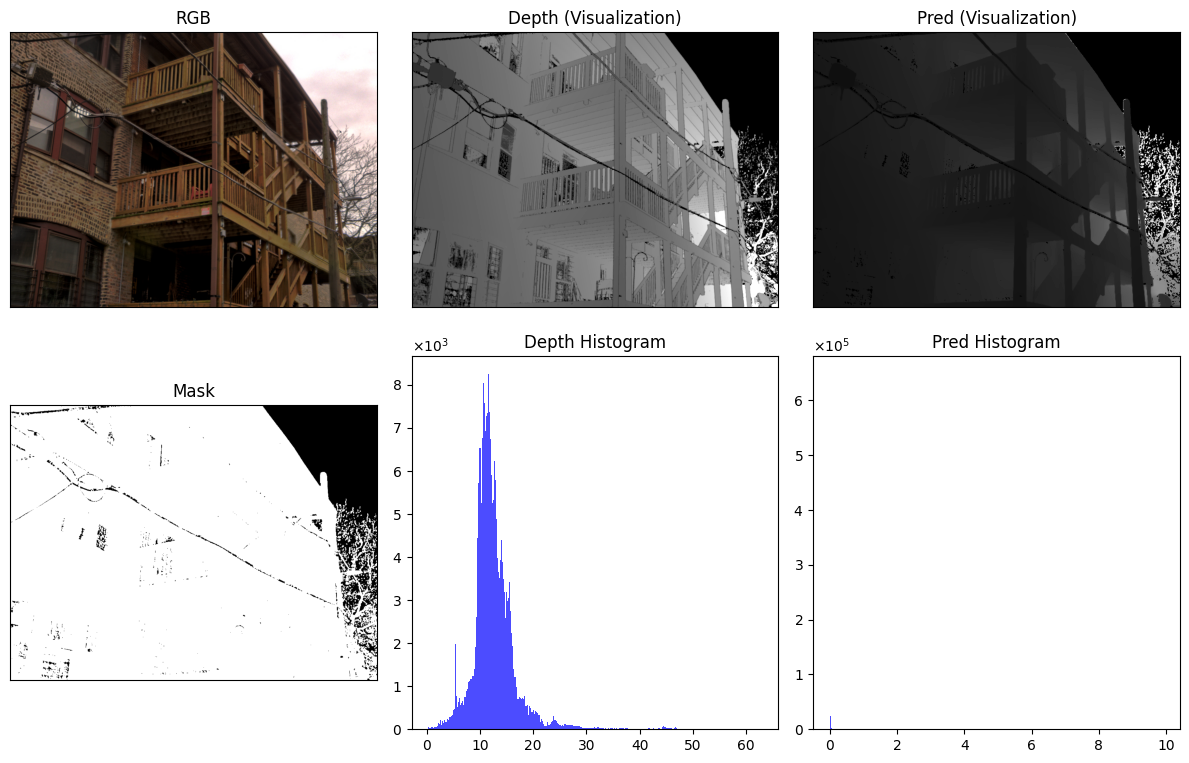

---- Depth Report ----

how many uniques: 665352
Max: 62.91366958618164
Min: 0.3028220236301422
Dtype: float32
---- Depth Report ----

how many uniques: 670508
Max: 9.91779613494873
Min: 0.0021810331381857395
Dtype: float32


In [7]:
depth_report(rgb, gt_depth_masked, pred_depth,mask=mask_full, cap=True, uint=True)

## 3. Alignment via least squares algorithm

In [8]:
def compute_scale_and_shift(prediction, target, mask):
        # h,w = prediction.shape
        # prediction = prediction.reshape((1,h,w))
        # target = target.reshape((1,h,w))
        # mask = mask.reshape((1,h,w))
        # system matrix: A = [[a_00, a_01], [a_10, a_11]]
        a_00 = np.sum(mask * prediction * prediction, (0,1))
        a_01 = np.sum(mask * prediction, (0,1))
        a_11 = np.sum(mask, (0,1))

        # right hand side: b = [b_0, b_1]
        b_0 = np.sum(mask * prediction * target, (0,1))
        b_1 = np.sum(mask * target, (0,1))

        # solution: x = A^-1 . b = [[a_11, -a_01], [-a_10, a_00]] / (a_00 * a_11 - a_01 * a_10) . b
        x_0 = np.zeros_like(b_0)
        x_1 = np.zeros_like(b_1)

        det = a_00 * a_11 - a_01 * a_01
        # A needs to be a positive definite matrix.
        valid = det > 0

        x_0[valid] = (a_11[valid] * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
        x_1[valid] = (-a_01[valid] * b_0[valid] + a_00[valid] * b_1[valid]) / det[valid]

        return x_0, x_1

In [9]:
x_0, x_1 = compute_scale_and_shift(pred_diode, gt_disp_capped, mask_full)

In [10]:
prediction_aligned = x_0 * pred_diode + x_1
prediction_aligned = np.squeeze(prediction_aligned)*mask_full

depth_aligned_masked = np.zeros_like(pred_diode)
depth_aligned_masked[mask_full == 1] = 1 / prediction_aligned[mask_full == 1]
depth_aligned_capped = cap_values(depth_aligned_masked, 2, 98)

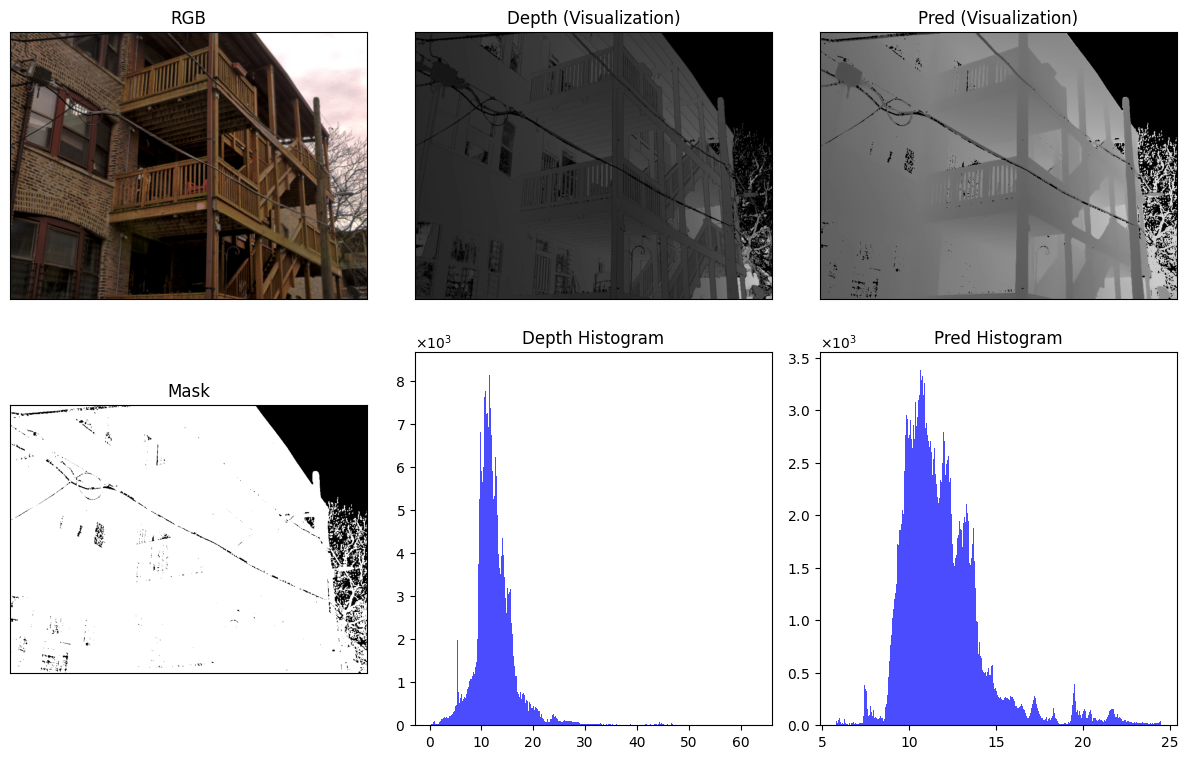

---- Depth Report ----

how many uniques: 665352
Max: 62.91366958618164
Min: 0.3028220236301422
Dtype: float32
---- Depth Report ----

how many uniques: 644925
Max: 24.481555938720703
Min: 5.794624328613281
Dtype: float32


In [11]:
depth_report(rgb, gt_depth_masked, depth_aligned_masked, mask=mask_full, cap=False, uint=False)

----------------

Visualization of a column of the groundtruth, and from the prediction. Then, align them both.

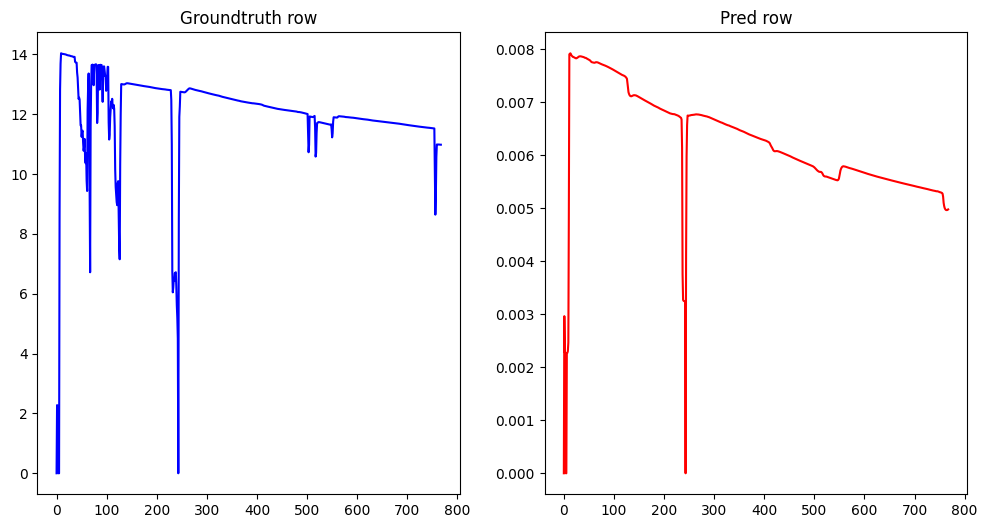

In [12]:
row_index = 300
GT_row = groundtruth[:, row_index]
pred_row = (pred_depth)[:, row_index]
pred_aligned_row = depth_aligned_capped[:, row_index]


fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot( GT_row, 'b')
ax[0].set_title("Groundtruth row")
ax[1].plot(pred_row, 'r')
ax[1].set_title("Pred row")
plt.show()

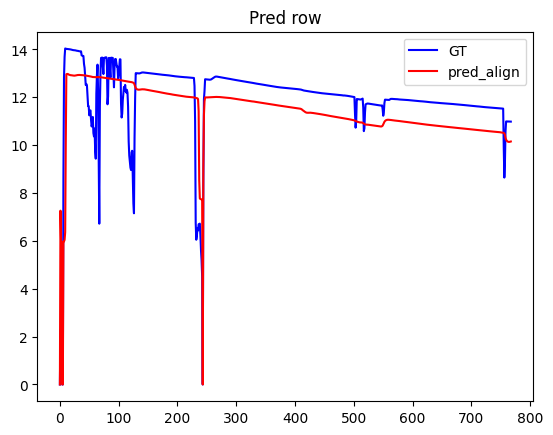

In [13]:
fig, ax = plt.subplots()
ax.plot(GT_row, 'b',label="GT")
ax.plot(pred_aligned_row, 'r', label="pred_align")
ax.set_title("Pred row")
ax.legend()
plt.show()

## 4. Calculate Metrics

### 4.1 metrics on groundtruth masked

In [14]:
abs_rel_error_mask(depth_aligned_masked, groundtruth, mask_full)

np.float32(0.1718744)

In [15]:
calculate_delta(depth_aligned_masked, groundtruth, mask_full, threshold=1.25)

np.float64(82.36216771834827)

### 4.2 metrics on groundtruth capped

In [16]:
abs_rel_error(depth_aligned_capped, gt_depth_capped)

np.float32(0.17065084)

In [17]:
abs_rel_error_mask(depth_aligned_capped, gt_depth_capped,mask_full)

np.float32(0.16579223)

In [18]:
calculate_delta(depth_aligned_capped, gt_depth_capped, mask_full, threshold=1.25)

np.float64(83.13474643588779)

## 5. Output the results